In [93]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk import collocations
import re, string
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import sparse
from sklearn import linear_model
plt.rcParams['figure.figsize'] = [16, 6]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geancarlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\geancarlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
def getxy(row_s, row_f, feature_cols=['content', 'followers', 'following', 'retweet'], label_col=['troll']):
    return df[feature_cols][row_s:row_f], df[label_col][row_s:row_f]

In [95]:
df_trolls = pd.read_csv("dataset_troll_trial.csv")
df_users = pd.read_csv("dataset_users.csv")
df = pd.concat([df_trolls, df_users])

In [106]:
df.sample(5).head()

,content,followers,following,retweet,created_at,troll,emoticones,sin_stopwords
773,Chocolates 😂😝,357,673,False,2019-08-07 21:52:52,False,😂 😝,chocolates
672,RT @atipak: Se mueren del miedo. Les aterra qu...,55,12,True,2019-08-17 20:26:19,True,,mueren miedo aterra barran urnas empiezan trat...
154,RT @kevlex_pazmino1: Admiro tu humildad; tu se...,14,184,True,2019-07-20 05:11:49,False,,admiro humildad sencillez inteligencia forma p...
1261,RT @elcomerciocom: #ATENCIÓN | Capturado en Co...,35,187,True,2019-08-11 18:19:32,True,»,atención capturado colombia disidente farc imp...
98,@FEGASG Con gusto Don Chulquero; pela verga; c...,2,16,False,2019-08-14 18:58:55,True,,gusto chulquero pela verga cara chancho


In [107]:
df.shape

(3972, 8)

In [97]:
df['retweet'].value_counts()

False    2423
True     1549
Name: retweet, dtype: int64

In [98]:
df['troll'].value_counts()

False    2580
True     1392
Name: troll, dtype: int64

In [99]:
stopwords_set = stopwords.words('spanish')
stopwords_set.extend(stopwords.words('english'))
stopwords_set = set(stopwords_set)

In [100]:
tweets_hashtags = set([])
tweets_full_lemmas = set([])

In [9]:
def limpieza_tweet(tweets):
    # quitando icons
    tweet = tweets["content"].lower()
    sin_icons = re.sub(r'\$\w*','',tweet)
    # obteniendo palabras
    tw_Tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    temp_tweet_list = tw_Tokenizer.tokenize(sin_icons)
    # quitando urls/direcciones
    sin_https = [re.sub(r'https?:\/\/.*\/\w*|t.co\/\w*','',i) for i in temp_tweet_list]
    # quitando hashtags
    tweets_hashtags.update(sin_https)
    sin_hashtags = [re.sub(r'#|https', '', i) for i in sin_https]
    # quitando signos de puntuación
    sin_puntuacion = [re.sub(r'[' + string.punctuation + ']+', ' ', i) for i in sin_hashtags]
    sin_puntuacion = [re.sub(r'[“’—‘”–…]+', ' ', i) for i in sin_puntuacion]
    
    new_tweet = ' '.join(sin_puntuacion)
    filtrada_palabras = tw_Tokenizer.tokenize(new_tweet)
    filtrada_palabras = [re.sub(r'^\w\w?$', '', i) for i in filtrada_palabras]
    
    filtrada =' '.join(filtrada_palabras)
    tweet_final = re.sub(r'\s\s+', ' ', filtrada)
    # quitando stopwords
    tweet_final = tweet_final.strip(' ').split(' ')
    sin_stopwords = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)>1 and not i.isdigit())]
    #obteniendo los emoticones para luego analizar
    emoticones = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)==1) ]
    # obtiendo lemas
    tweets_full_lemmas.update(sin_stopwords)
    tweets["emoticones"] = ' '.join(emoticones)
    tweets["sin_stopwords"] = ' '.join(sin_stopwords)
    return tweets

In [101]:
df = df.apply(limpieza_tweet, axis=1)

In [102]:
df.sample(5).head()

,content,followers,following,retweet,created_at,troll,emoticones,sin_stopwords
503,@CNEL_EP Gracias CNEL EP,1,36,False,2019-08-16 12:25:33,True,,gracias cnel
418,@PPKbancada @YeseniaPonceV Esperamos que @CFlo...,1092,1692,False,2019-08-15 21:58:26,False,,esperamos vaya final allí sólo lealtad compañe...
1157,RT @jcarlostuarez: Sufrí linchamiento mediátic...,11,217,True,2019-08-17 15:56:35,True,,sufrí linchamiento mediático persecución polít...
1325,@eluniversocom Todo lo que está pasando es cul...,1,63,False,2019-05-07 10:04:22,True,,pasando culpa correa
218,QUITO: Representantes de Yasunidos continúan c...,9516,1128,False,2019-08-16 15:02:15,False,,quito representantes yasunidos continúan toma ...


In [103]:
texto = df["sin_stopwords"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
palabras = nltk.tokenize.word_tokenize(texto, language="spanish")
distribucion = nltk.FreqDist(palabras)
frecuencia = pd.DataFrame(distribucion.most_common(20),columns=['Palabra', 'Frequencia']).set_index('Palabra')

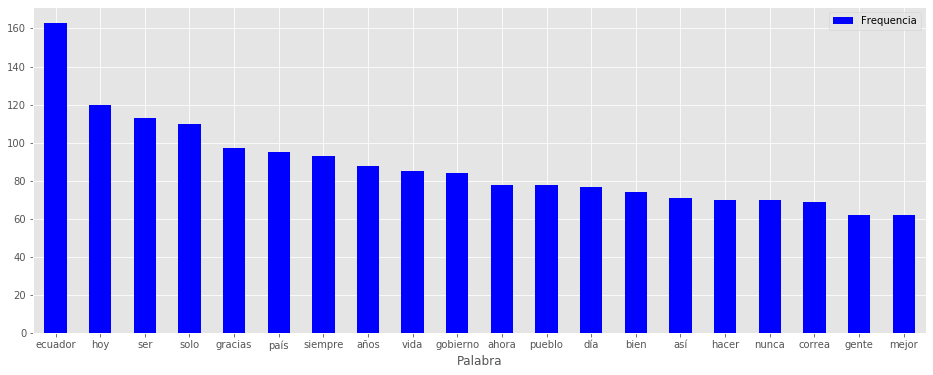

In [104]:
matplotlib.style.use('ggplot')
frecuencia.plot.bar(rot=0, color="blue")

In [105]:
df = df.sample(frac=1)

In [108]:
X_train, y_train = getxy(0,2972)

In [109]:
X_test, y_test = getxy(2973,3971)

In [110]:
X_train.shape, y_test.shape

((2972, 4), (998, 1))

In [111]:
X_test.shape, y_test.shape

((998, 4), (998, 1))

### Tokenize words

In [112]:
vocab_size=5000
tokenizer=feature_extraction.text.CountVectorizer(stop_words=stopwords_set, max_features=vocab_size)
tokenizer=tokenizer.fit(df['sin_stopwords'])

In [113]:
X_train_tok=tokenizer.transform(X_train['content'])
X_test_tok=tokenizer.transform(X_test['content'])

### Standarize followers/following

In [114]:
scaler = preprocessing.StandardScaler().fit(X_train[['followers','following']])

In [118]:
'rand means and scales: {}, {}'.format(scaler.mean_, scaler.scale_)

'rand means and scales: [2848.76177658  603.73485868], [19260.73220381  1479.42450242]'

In [119]:
col_to_std = ['followers', 'following']
X_train[col_to_std]=scaler.transform(X_train[col_to_std])
X_test[col_to_std]=scaler.transform(X_test[col_to_std])

In [120]:
X_train[col_to_std].head()

,followers,following
2046,-0.147913,-0.408364
583,-0.147913,-0.408364
2269,-0.147913,-0.408363
2255,-0.147913,-0.408364
336,-0.147913,-0.408364


### Binarize outcome

In [121]:
y_train.head()

,troll
2046,False
583,False
2269,False
2255,False
336,False


In [124]:
bool_to_bin = lambda x: 1 if x else 0
y_train['troll'] = y_train['troll'].apply(bool_to_bin)
y_test['troll'] = y_test['troll'].apply(bool_to_bin)

# binarize retweet colum
X_train['retweet'] = X_train['retweet'].apply(bool_to_bin)
X_test['retweet'] = X_test['retweet'].apply(bool_to_bin)

### Concatenate features

In [125]:
def concatenate_features(tok_matrix, data_df):
    """ concatenate the tokenized matrix (scipy.sparse) with other features """
    sparse_cols = sparse.csr_matrix(data_df[['followers', 'following', 'retweet']])
    combined = sparse.hstack([tok_matrix, sparse_cols])
    return combined

In [126]:
X_train_combined = concatenate_features(X_train_tok, X_train)
X_test_combined = concatenate_features(X_test_tok, X_test)

In [127]:
X_train_combined.shape

(2972, 5003)

## Training the model - Logistic Regresion

In [128]:
logic_model = linear_model.LogisticRegression().fit(X_train_combined, y_train['troll'])

C:\Users\geancarlo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [130]:
logic_model.score(X_train_combined, y_train['troll'])

0.9313593539703903

In [131]:
logic_model.score(X_test_combined, y_test['troll'])

0.7925851703406813